In [1]:
%reload_ext autoreload
%autoreload 2

Failed to read module file 'C:\Python\Python311\Lib\shlex.py' for module 'shlex': UnicodeDecodeError
Traceback (most recent call last):
  File "c:\Users\Braian\OneDrive\Escritorio\GitHub\CEIA\feinn_project\.venv\Lib\site-packages\IPython\core\extensions.py", line 62, in load_extension
    return self._load_extension(module_str)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Braian\OneDrive\Escritorio\GitHub\CEIA\feinn_project\.venv\Lib\site-packages\IPython\core\extensions.py", line 77, in _load_extension
    mod = import_module(module_str)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python\Python311\Lib\importlib\__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1206, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1178, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1142, in _fi

In this example, we explore the capabilities of FEINN in solving an soft matrix reinforced with a hard fiber. It is subjected to uniform normal traction under a plane-stress condition.

### General Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In this case, we load a mesh created using SMESH module from Salome Meca platform.

In [3]:
from mesher import Mesh2D

mesh = Mesh2D.from_salome_med(filepath = './MatrixFiberRVE.med')

Loaded SALOME .med mesh: 817 nodes, 988 elements
Node groups (4): ['left_e', 'right_e', 'top_e', 'bottom_e']
Element groups (7): ['all', 'fiber_s', 'matrix_s', 'bottom_e', 'top_e', 'right_e', 'left_e']


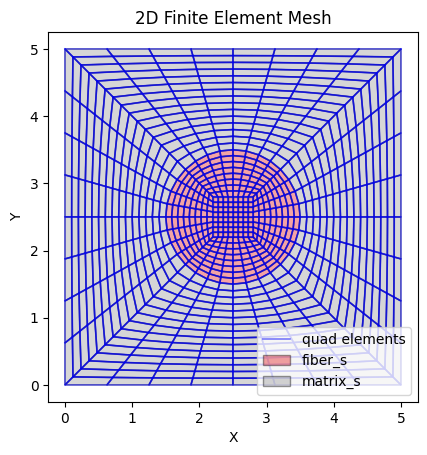

In [4]:
mesh.plot(show_nodes=False, element_groups_to_plot=['fiber_s','matrix_s'])

### Dirichlet boundary conditions

In [5]:
from solver import BoundaryCondition

bcs = {
        'left_e': [BoundaryCondition(dof=1, value=0.0),
                BoundaryCondition(dof=2, value=0.0)]             
        }

### Define material

In [6]:
from materials import LinearElastic

soft = LinearElastic(emod = 1, nu = 0.30)
hard = LinearElastic(emod = 10, nu = 0.30)

matfield = {'matrix_s': soft, 
            'fiber_s': hard}

### von Neumman boundary conditions

In [7]:
from solver import LineLoad

traction = {
            'right_e': LineLoad(fx = 1.0, fy = 0, reference = "global"),
            }


### Model

In [8]:
from solver import NFEA

fem_solver = NFEA(mesh = mesh, 
                      bcs = bcs, 
                      matfld = matfield,
                      line_loads = traction,
                      verbose = True
                      )



[matfld] Assigned: ['matrix_s', 'fiber_s']
[matfld] All 800 quad elements have assigned material
[line_load] Applied 1 line load groups
[BC] Processed 2 Dirichlet condition(s) → 18 total constraint(s)
[BC] Applied Dirichlet BCs → 18 fixed DOFs


In [9]:
fem_solver.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 1.03e-13  Energetic error: 1.00e+00
Iter   2 | du error: 7.84e-14  Res error: 3.21e-14  Energetic error: -8.16e-15
Converged in 2 iterations


In [10]:
fem_solver.udisp

tensor([1.6114, 0.0306, 0.0000,  ..., 0.0112, 1.7175, 0.0114],
       dtype=torch.float64)

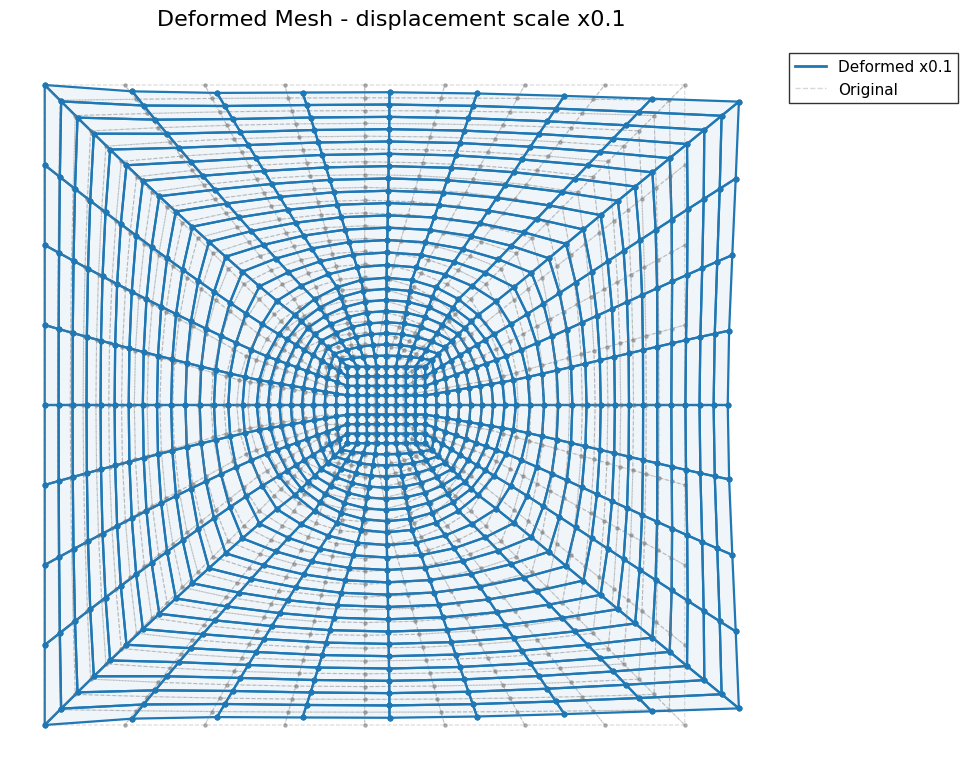

In [11]:
fem_solver.plot_deformed_mesh(scale=0.1)

In [12]:
from solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=mesh,
    bcs=bcs,
    matfld=matfield,
    line_loads = traction,
    verbose=False,
    nnet = mFCNet(num_layers=6, num_neurons=64, activation=nn.ReLU, isFourier=True),
    bc_weight=1e4,
    nnet_init = 'xavier',
    )

In [13]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 20000
cfg.learning_rate = 5e-3
cfg.lr_min = 1e-5

26.1
22.8
10.4

In [14]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

from trainer import ReLoBraLoBalancer
balancer = ReLoBraLoBalancer(alpha=0.5, rho=0.999, temperature=0.1, lookback_prob=0.05)

# Entrenar
feinn_solver.train(epochs = cfg.epochs,
                   optimizer=optimizer,
                   balancer=balancer,
                   scheduler=scheduler,
                   lbfgs_epochs = 50,
                   warmup = True, 
                   verbose = True)

[FEINN] Starting warmup for zero initial displacement
Warmup loss: 5.78e-02
[FEINN] Warmup completado - salida inicial ≈ 0
[FEINN] Zero-output init: max |u| inicial = 1.66e+00

Epoch 1/20000
Total Loss: 1.507e+04
  Domain: 1.498e+04
  BC:     8.621e+01

Epoch 500/20000
Total Loss: 1.407e+01
  Domain: 1.340e+01
  BC:     5.844e-04

Epoch 1000/20000
Total Loss: 6.819e+01
  Domain: 6.733e+01
  BC:     8.573e-01

Epoch 1500/20000
Total Loss: 1.326e+00
  Domain: 1.279e+00
  BC:     2.215e-03

Epoch 2000/20000
Total Loss: 8.313e-01
  Domain: 8.113e-01
  BC:     1.108e-02

Epoch 2500/20000
Total Loss: 6.946e+00
  Domain: 4.783e+00
  BC:     2.167e+00

Epoch 3000/20000
Total Loss: 2.038e+00
  Domain: 1.938e+00
  BC:     1.603e-02

Epoch 3500/20000
Total Loss: 1.368e+02
  Domain: 2.422e+01
  BC:     1.095e+02

Epoch 4000/20000
Total Loss: 1.668e-01
  Domain: 1.615e-01
  BC:     1.271e-04

Epoch 4500/20000
Total Loss: 2.640e-01
  Domain: 2.348e-01
  BC:     5.459e-03

Epoch 5000/20000
Total Loss

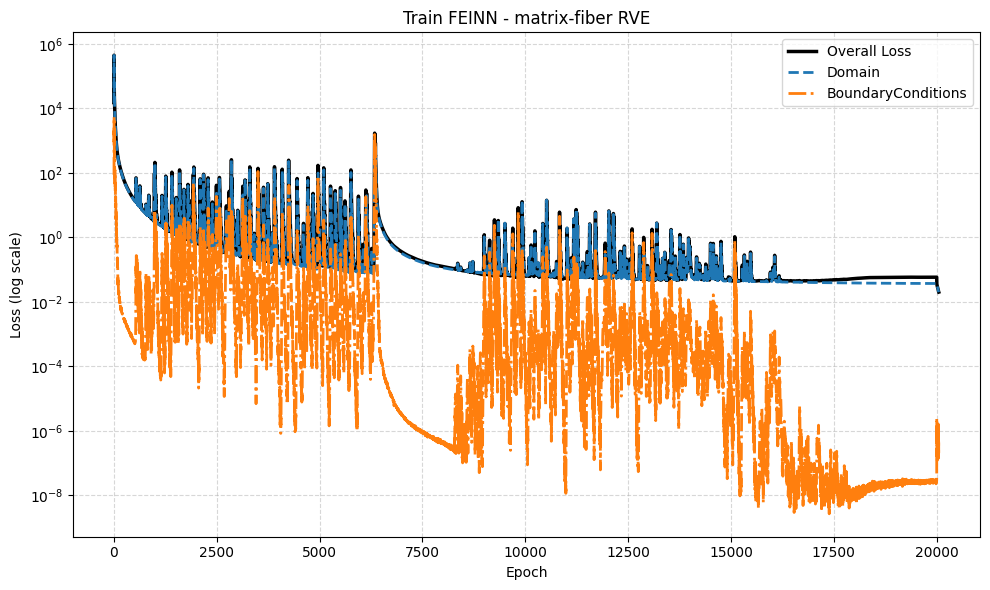

In [15]:
feinn_solver.plot_history(title="Train FEINN - matrix-fiber RVE")

C:\Users\Braian\OneDrive\Escritorio\GitHub\CEIA\feinn_project\src\evaluator.py:36: RuntimeWarning: divide by zero encountered in divide
  100 * np.abs((self.y_pred - self.y_true) / self.y_true),


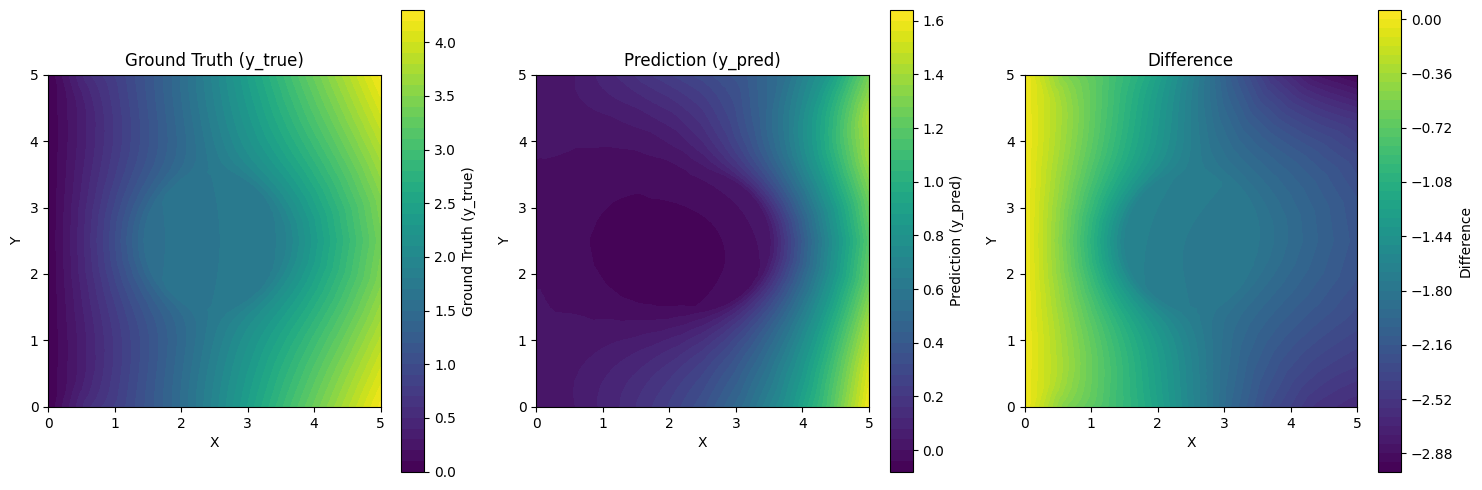

In [16]:
from evaluator import SolutionComparator
comparator = SolutionComparator(mesh, fem_solver.udisp[::2], feinn_solver.udisp[::2])
comparator.plot_comparison(metric='difference')

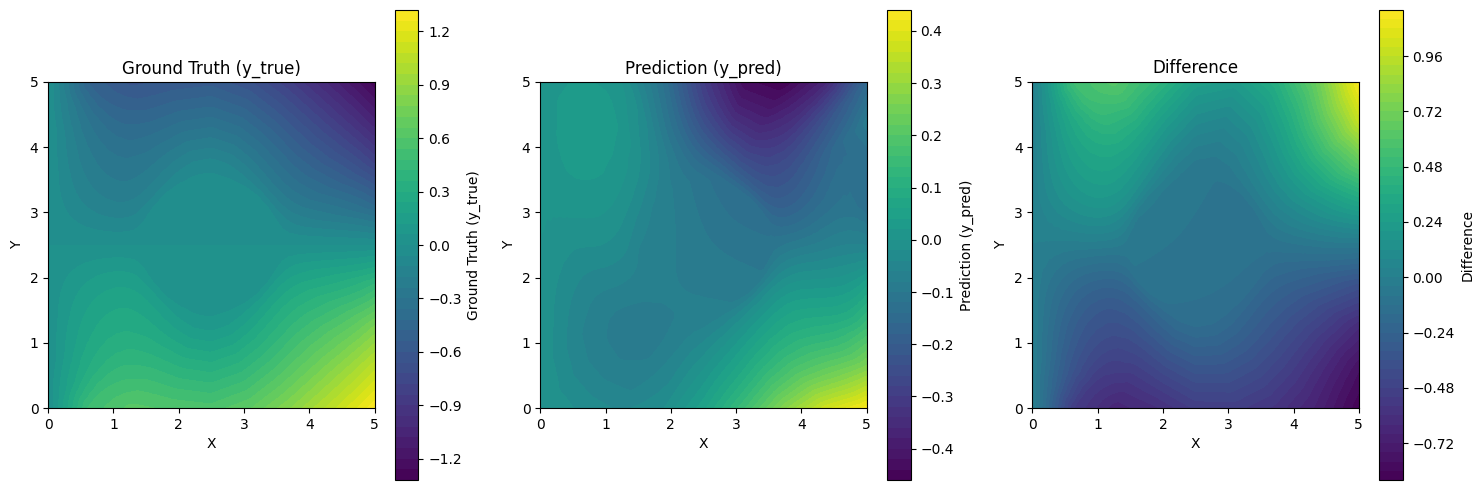

In [17]:
comparator = SolutionComparator(mesh, fem_solver.udisp[1::2], feinn_solver.udisp[1::2])
comparator.plot_comparison(metric='difference')

In [18]:
feinn_solver.train(epochs = 0,
                   lbfgs_epochs = 100,
                   warmup = False, 
                   verbose = True)


Epoch 1/100 (L-BFGS)
Total Loss: 1.977e-02
  Domain: 1.977e-02
  BC:     3.717e-07

Epoch 10/100 (L-BFGS)
Total Loss: 1.807e-02
  Domain: 1.807e-02
  BC:     1.075e-06

Epoch 20/100 (L-BFGS)
Total Loss: 1.498e-02
  Domain: 1.498e-02
  BC:     1.669e-07

Epoch 30/100 (L-BFGS)
Total Loss: 1.250e-02
  Domain: 1.250e-02
  BC:     8.446e-08

Epoch 40/100 (L-BFGS)
Total Loss: 1.071e-02
  Domain: 1.071e-02
  BC:     4.022e-07

Epoch 50/100 (L-BFGS)
Total Loss: 8.669e-03
  Domain: 8.669e-03
  BC:     1.838e-07

Epoch 60/100 (L-BFGS)
Total Loss: 6.972e-03
  Domain: 6.972e-03
  BC:     2.062e-07

Epoch 70/100 (L-BFGS)
Total Loss: 5.539e-03
  Domain: 5.539e-03
  BC:     4.156e-07

Epoch 80/100 (L-BFGS)
Total Loss: 4.710e-03
  Domain: 4.710e-03
  BC:     1.556e-07

Epoch 90/100 (L-BFGS)
Total Loss: 3.933e-03
  Domain: 3.933e-03
  BC:     6.099e-08

Epoch 100/100 (L-BFGS)
Total Loss: 3.372e-03
  Domain: 3.372e-03
  BC:     7.334e-08
 Maximum gradient (Inf-Norm): 6.23e-02


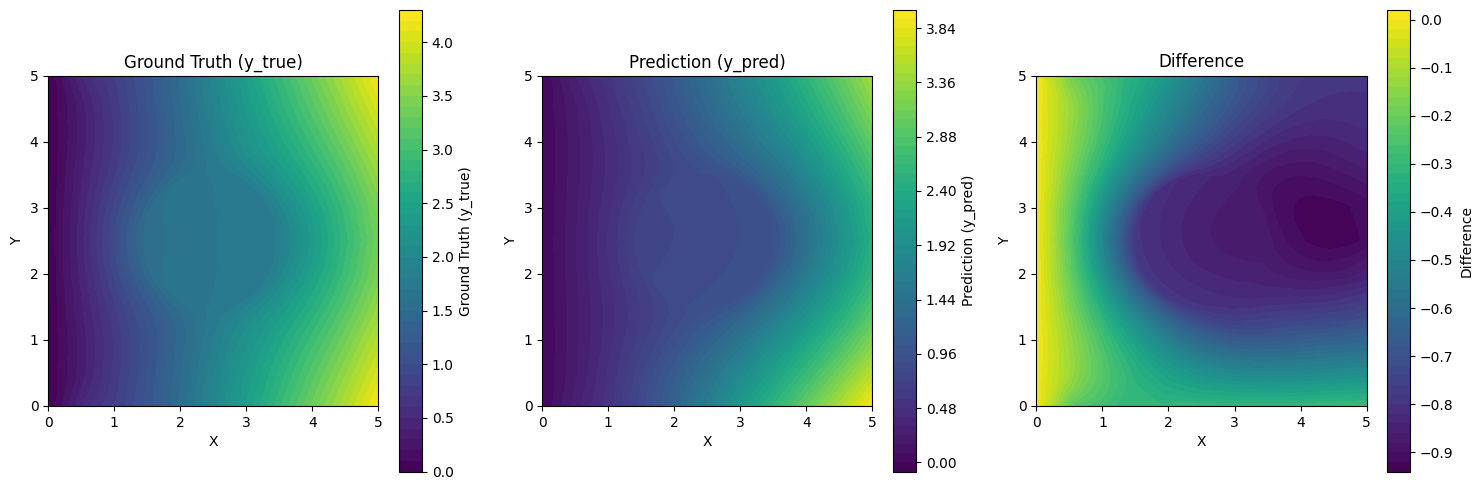

In [19]:
from evaluator import SolutionComparator
comparator = SolutionComparator(mesh, fem_solver.udisp[::2], feinn_solver.udisp[::2])
comparator.plot_comparison(metric='difference')

In [20]:
feinn_solver.train(epochs = 0,
                   lbfgs_epochs = 100,
                   warmup = False, 
                   verbose = True)


Epoch 1/100 (L-BFGS)
Total Loss: 3.330e-03
  Domain: 3.330e-03
  BC:     2.796e-08

Epoch 10/100 (L-BFGS)
Total Loss: 2.960e-03
  Domain: 2.960e-03
  BC:     9.003e-08

Epoch 20/100 (L-BFGS)
Total Loss: 2.662e-03
  Domain: 2.662e-03
  BC:     3.782e-08

Epoch 30/100 (L-BFGS)
Total Loss: 2.434e-03
  Domain: 2.434e-03
  BC:     2.675e-08

Epoch 40/100 (L-BFGS)
Total Loss: 2.174e-03
  Domain: 2.174e-03
  BC:     3.055e-08

Epoch 50/100 (L-BFGS)
Total Loss: 1.942e-03
  Domain: 1.942e-03
  BC:     1.506e-08

Epoch 60/100 (L-BFGS)
Total Loss: 1.767e-03
  Domain: 1.767e-03
  BC:     4.094e-08

Epoch 70/100 (L-BFGS)
Total Loss: 1.590e-03
  Domain: 1.590e-03
  BC:     3.853e-08

Epoch 80/100 (L-BFGS)
Total Loss: 1.383e-03
  Domain: 1.383e-03
  BC:     4.440e-08

Epoch 90/100 (L-BFGS)
Total Loss: 1.143e-03
  Domain: 1.143e-03
  BC:     1.456e-08

Epoch 100/100 (L-BFGS)
Total Loss: 9.657e-04
  Domain: 9.656e-04
  BC:     5.965e-08
 Maximum gradient (Inf-Norm): 3.28e-02


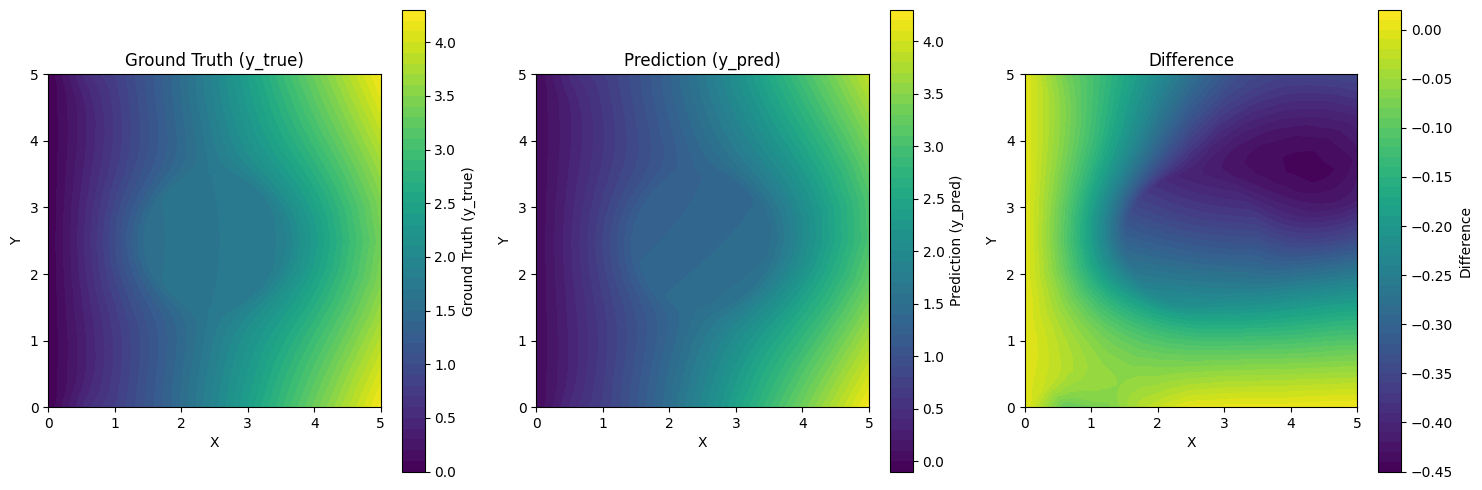

In [21]:
from evaluator import SolutionComparator
comparator = SolutionComparator(mesh, fem_solver.udisp[::2], feinn_solver.udisp[::2])
comparator.plot_comparison(metric='difference')

In [22]:
feinn_solver.train(epochs = 0,
                   lbfgs_epochs = 100,
                   warmup = False, 
                   verbose = True)


Epoch 1/100 (L-BFGS)
Total Loss: 9.477e-04
  Domain: 9.477e-04
  BC:     2.533e-08

Epoch 10/100 (L-BFGS)
Total Loss: 7.967e-04
  Domain: 7.967e-04
  BC:     1.565e-08

Epoch 20/100 (L-BFGS)
Total Loss: 6.710e-04
  Domain: 6.710e-04
  BC:     1.405e-08

Epoch 30/100 (L-BFGS)
Total Loss: 5.787e-04
  Domain: 5.787e-04
  BC:     8.024e-09

Epoch 40/100 (L-BFGS)
Total Loss: 4.735e-04
  Domain: 4.735e-04
  BC:     1.863e-08

Epoch 50/100 (L-BFGS)
Total Loss: 3.733e-04
  Domain: 3.733e-04
  BC:     1.080e-08

Epoch 60/100 (L-BFGS)
Total Loss: 2.845e-04
  Domain: 2.845e-04
  BC:     6.978e-09

Epoch 70/100 (L-BFGS)
Total Loss: 2.210e-04
  Domain: 2.210e-04
  BC:     1.061e-08

Epoch 80/100 (L-BFGS)
Total Loss: 1.746e-04
  Domain: 1.746e-04
  BC:     5.347e-09

Epoch 90/100 (L-BFGS)
Total Loss: 1.492e-04
  Domain: 1.492e-04
  BC:     4.010e-09

Epoch 100/100 (L-BFGS)
Total Loss: 1.347e-04
  Domain: 1.347e-04
  BC:     4.689e-09
 Maximum gradient (Inf-Norm): 8.05e-03


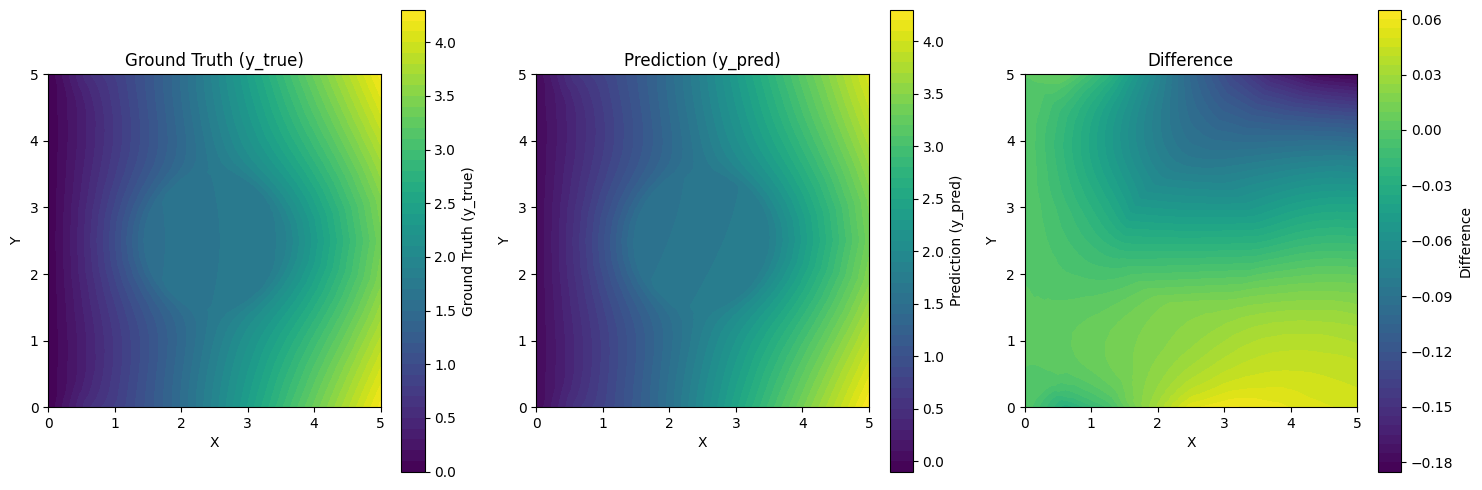

In [23]:
from evaluator import SolutionComparator
comparator = SolutionComparator(mesh, fem_solver.udisp[::2], feinn_solver.udisp[::2])
comparator.plot_comparison(metric='difference')

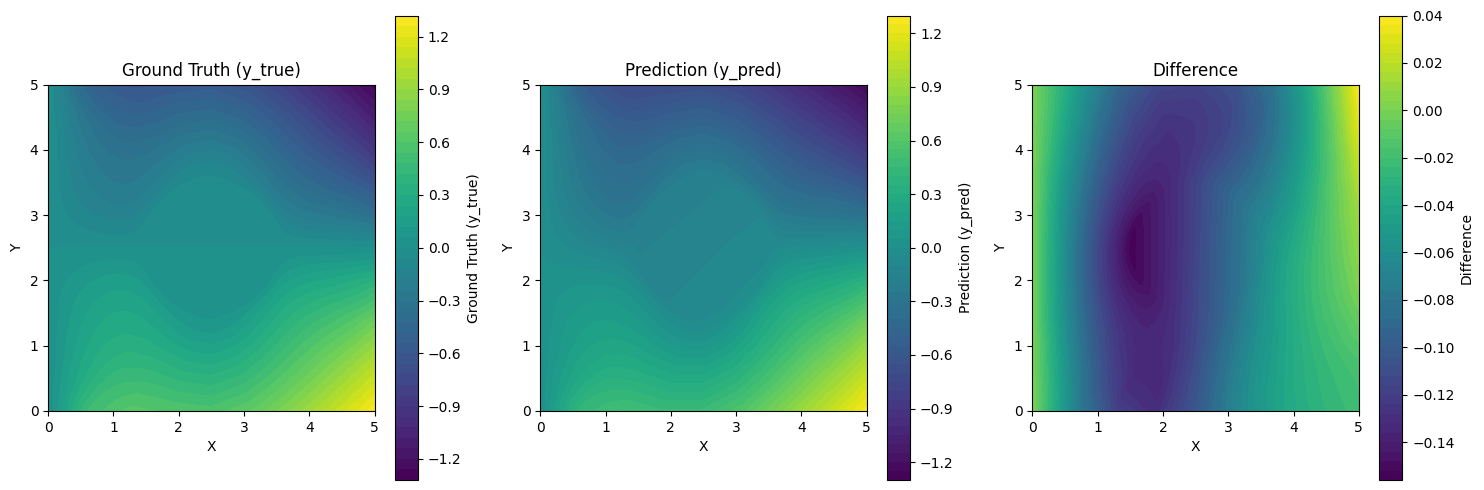

In [24]:
comparator = SolutionComparator(mesh, fem_solver.udisp[1::2], feinn_solver.udisp[1::2])
comparator.plot_comparison(metric='difference')